In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
np.random.seed(2)

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Input
from keras.models import load_model

In [117]:
df = pd.read_csv("fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [118]:
df.groupby('Usage').count()

,emotion,pixels
Usage,,
PrivateTest,3589,3589
PublicTest,3589,3589
Training,28709,28709


In [119]:
df.groupby('emotion').count()

,pixels,Usage
emotion,,
0,4953,4953
1,547,547
2,5121,5121
3,8989,8989
4,6077,6077
5,4002,4002
6,6198,6198


In [120]:
train = df[df.Usage == 'Training']
val = df[df.Usage == 'PublicTest']
test = df[df.Usage == 'PrivateTest']

In [121]:
train = train.drop(labels=['Usage'], axis=1)
val = val.drop(labels=['Usage'], axis=1)
test = test.drop(labels=['Usage'], axis=1)

In [122]:
y_train = train["emotion"]
y_val = val["emotion"]
y_test = test["emotion"]

X_train = train["pixels"]
X_val = val["pixels"]
X_test = test["pixels"]

In [123]:
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X = X/255.0
    X = X.reshape(-1, 48, 48, 1)
    return X

In [124]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

In [125]:
print("Is any label null in training set:", y_train.isnull().any())
print("Is any label null in validation set:", y_val.isnull().any())
print("Is any label null in testing set:", y_test.isnull().any())

y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

Is any label null in training set: False
Is any label null in validation set: False
Is any label null in testing set: False


In [126]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="Same", activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))

model.add(Conv2D(256, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))

model.add(Flatten())
#model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [127]:
# simple early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1)
optimizer = opt.Adam(lr = 0.001)
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)

In [128]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [129]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size = 100, callbacks=[es,lr_anneal])
end = time.time()
print('Elasped Time in minutes:  %.2f' % (end - start)/60)

Epoch 1/50
288/288 [==============================] - 26s 86ms/step - loss: 2.4515 - accuracy: 0.2320 - val_loss: 1.9248 - val_accuracy: 0.1694
Epoch 2/50
288/288 [==============================] - 24s 85ms/step - loss: 1.5964 - accuracy: 0.3746 - val_loss: 1.6490 - val_accuracy: 0.3600
Epoch 3/50
288/288 [==============================] - 24s 85ms/step - loss: 1.4295 - accuracy: 0.4466 - val_loss: 1.3462 - val_accuracy: 0.4912
Epoch 4/50
288/288 [==============================] - 24s 85ms/step - loss: 1.3248 - accuracy: 0.4910 - val_loss: 1.2709 - val_accuracy: 0.5202
Epoch 5/50
288/288 [==============================] - 24s 84ms/step - loss: 1.2656 - accuracy: 0.5172 - val_loss: 1.3528 - val_accuracy: 0.4859
Epoch 6/50
288/288 [==============================] - 24s 84ms/step - loss: 1.2143 - accuracy: 0.5398 - val_loss: 1.1886 - val_accuracy: 0.5472
Epoch 7/50
288/288 [==============================] - 24s 85ms/step - loss: 1.1738 - accuracy: 0.5541 - val_loss: 1.1301 - val_accuracy:

In [130]:
model.save('final_model.h5')

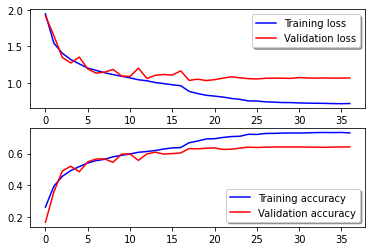

In [131]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [135]:
save_model = load_model('final_model.h5')

In [149]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    labels = "0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral"
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label \n\n' + labels)

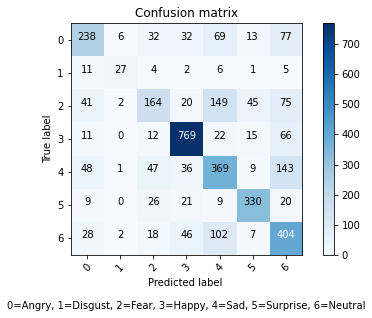

In [151]:
# Predict the values from the validation dataset
y_pred = save_model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))


In [152]:
score, acc = save_model.evaluate(X_test, y_test, verbose=0)
print('Test score: %.3f'% score)
print('Test accuracry: %.3f' % (acc * 100.0))

Test score: 0.991
Test accuracry: 66.091
